In [1]:
!pip install hmmlearn
!pip install simplejson
!pip install eyed3
!pip install pydub
!pip install pyAudioAnalysis

     |████████████████████████████████| 374 kB 8.4 MB/s 
     |████████████████████████████████| 130 kB 7.5 MB/s 
     |████████████████████████████████| 245 kB 7.9 MB/s 
     |████████████████████████████████| 242 kB 16.1 MB/s 
  Attempting uninstall: coverage
    Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires coverage==3.7.1, but you have coverage 5.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
coveralls 0.5 requires coverage<3.999,>=3.6, but you have coverage 5.5 which is incompatible.
     |████████████████████████████████| 41.3 MB 1.3 MB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.13-py3-none-any.whl size=4126432

In [2]:
import glob
import os
import eyed3
import ntpath
import numpy as np
from scipy.io import wavfile
import aifc
from pydub import AudioSegment

### These functions taken from pyAudioAnalysis library

In [3]:
def convert_dir_mp3_to_wav(audio_folder, sampling_rate, num_channels,
                           use_tags=False):
    """
    This function converts the MP3 files stored in a folder to WAV. If required,
    the output names of the WAV files are based on MP3 tags, otherwise the same
    names are used.
    ARGUMENTS:
     - audio_folder:    the path of the folder where the MP3s are stored
     - sampling_rate:   the sampling rate of the generated WAV files
     - num_channels:    the number of channels of the generated WAV files
     - use_tags:        True if the WAV filename is generated on MP3 tags
    """

    types = (audio_folder + os.sep + '*.mp3',)  # the tuple of file types
    files_list = []

    for files in types:
        files_list.extend(glob.glob(files))

    for f in files_list:
        audio_file = eyed3.load(f)
        if use_tags and audio_file.tag != None:
            artist = audio_file.tag.artist
            title = audio_file.tag.title
            if artist != None and title != None:
                if len(title) > 0 and len(artist) > 0:
                    filename = ntpath.split(f)[0] + os.sep + \
                                  artist.replace(","," ") + " --- " + \
                                  title.replace(","," ") + ".wav"
                else:
                    filename = f.replace(".mp3", ".wav")
            else:
                filename = f.replace(".mp3", ".wav")
        else:
            filename = f.replace(".mp3", ".wav")
        command = "ffmpeg -i \"" + f + "\" -ar " + str(sampling_rate) + \
                  " -ac " + str(num_channels) + " \"" + filename + "\""
        print(command)
        os.system(
            command.encode('ascii', 'ignore').decode('unicode_escape').replace(
                "\0", ""))

In [4]:
def read_audio_file(input_file):
    """
    This function returns a numpy array that stores the audio samples of a
    specified WAV of AIFF file
    """

    sampling_rate = 0
    signal = np.array([])
    if isinstance(input_file, str):
        extension = os.path.splitext(input_file)[1].lower()
        if extension in ['.aif', '.aiff']:
            sampling_rate, signal = read_aif(input_file)
        elif extension in ['.wav']:
            sampling_rate, signal = wavfile.read(input_file) # from scipy.io
        elif extension in [".mp3", ".au", ".ogg"]:
            sampling_rate, signal = read_audio_generic(input_file)
        else:
            print("Error: unknown file type {extension}")
    else:
        sampling_rate, signal = read_audio_generic(input_file)

    if signal.ndim == 2 and signal.shape[1] == 1:
        signal = signal.flatten()

    return sampling_rate, signal

In [5]:
def read_aif(path):
    """
    Read audio file with .aif extension
    """
    sampling_rate = -1
    signal = np.array([])
    try:
        with aifc.open(path, 'r') as s:
            nframes = s.getnframes()
            strsig = s.readframes(nframes)
            signal = np.fromstring(strsig, np.short).byteswap()
            sampling_rate = s.getframerate()
    except:
        print("Error: read aif file. (DECODING FAILED)")
    return sampling_rate, signal


def read_audio_generic(input_file):
    """
    Function to read audio files with the following extensions
    [".mp3", ".au", ".ogg"], containing PCM (int16 or int32) data 
    """
    sampling_rate = -1
    signal = np.array([])
    try:
        audiofile = AudioSegment.from_file(input_file)
        data = np.array([])
        if audiofile.sample_width == 2:
            data = np.fromstring(audiofile._data, np.int16)
        elif audiofile.sample_width == 4:
            data = np.fromstring(audiofile._data, np.int32)

        if data.size > 0:
            sampling_rate = audiofile.frame_rate
            temp_signal = []
            for chn in list(range(audiofile.channels)):
                temp_signal.append(data[chn::audiofile.channels])
            signal = np.array(temp_signal).T
    except:
        print("Error: file not found or other I/O error. (DECODING FAILED)")
    return sampling_rate, signal


def stereo_to_mono(signal):
    """
    This function converts the input signal
    (stored in a numpy array) to MONO (if it is STEREO)
    """

    if signal.ndim == 2:
        if signal.shape[1] == 1:
            signal = signal.flatten()
        else:
            if signal.shape[1] == 2:
                signal = (signal[:, 1] / 2) + (signal[:, 0] / 2)
    return signal

In [6]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures, MidTermFeatures
import matplotlib.pyplot as plt
from pprint import pprint

In [8]:
# Converting mp3 to wav file
convert_dir_mp3_to_wav(".", 44100, 2)

Lame tag CRC check failed


ffmpeg -i "./president_speech.mp3" -ar 44100 -ac 2 "./president_speech.wav"


In [10]:
import IPython
IPython.display.Audio("president_speech.wav")

In [ ]:
# reading wav file and converting it to single (mono) channel
[Fs, x] = audioBasicIO.read_audio_file("friends2.wav")
signal = audioBasicIO.stereo_to_mono(x)

In [ ]:
x.shape

(6038674, 2)

### Extracting short features and mid features (total=64)

In [ ]:
F, f_names = ShortTermFeatures.feature_extraction(signal, Fs, 0.050*Fs, 0.025*Fs)

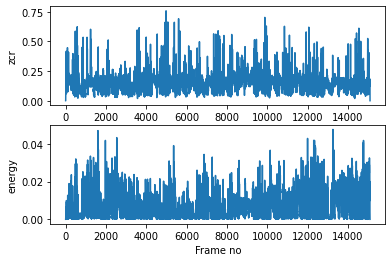

In [ ]:
plt.subplot(2,1,1); plt.plot(F[0,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[0]) 
plt.subplot(2,1,2); plt.plot(F[1,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[1]); plt.show()

In [ ]:
F.shape

(68, 15095)

In [ ]:
len(f_names)

68

In [ ]:
print(f_names, end=",")

['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std', 'delta zcr', 'delta energy', 'delta energy_entropy', 'delta spectral_centroid', 'delta spectral_spread', 'delta spectral_entropy', 'delta spectral_flux', 'delta spectral_rolloff', 'delta mfcc_1', 'delta mfcc_2', 'delta mfcc_3', 'delta mfcc_4', 'delta mfcc_5', 'delta mfcc_6', 'delta mfcc_7', 'delta mfcc_8', 'delta mfcc_9', 'delta mfcc_10', 'delta mfcc_11', 'delta mfcc_12', 'delta mfcc_13', 'delta chroma_1', 'delta chroma_2', 'delta chroma_3', 'delta chroma_4', 'delta chroma_5', 'delta chroma_6', 'delta chroma_7', 'delta chroma_8', 'delta chroma_9', 'delta chroma_10',

In [ ]:
mid_features, short_features, mid_feature_names = MidTermFeatures.mid_feature_extraction(signal, Fs, 0.050*Fs, 0.025*Fs, 0.050*Fs, 0.025*Fs)

In [ ]:
F[0].shape

(15095,)

In [ ]:
mid_feature_names

['zcr_mean',
 'energy_mean',
 'energy_entropy_mean',
 'spectral_centroid_mean',
 'spectral_spread_mean',
 'spectral_entropy_mean',
 'spectral_flux_mean',
 'spectral_rolloff_mean',
 'mfcc_1_mean',
 'mfcc_2_mean',
 'mfcc_3_mean',
 'mfcc_4_mean',
 'mfcc_5_mean',
 'mfcc_6_mean',
 'mfcc_7_mean',
 'mfcc_8_mean',
 'mfcc_9_mean',
 'mfcc_10_mean',
 'mfcc_11_mean',
 'mfcc_12_mean',
 'mfcc_13_mean',
 'chroma_1_mean',
 'chroma_2_mean',
 'chroma_3_mean',
 'chroma_4_mean',
 'chroma_5_mean',
 'chroma_6_mean',
 'chroma_7_mean',
 'chroma_8_mean',
 'chroma_9_mean',
 'chroma_10_mean',
 'chroma_11_mean',
 'chroma_12_mean',
 'chroma_std_mean',
 'delta zcr_mean',
 'delta energy_mean',
 'delta energy_entropy_mean',
 'delta spectral_centroid_mean',
 'delta spectral_spread_mean',
 'delta spectral_entropy_mean',
 'delta spectral_flux_mean',
 'delta spectral_rolloff_mean',
 'delta mfcc_1_mean',
 'delta mfcc_2_mean',
 'delta mfcc_3_mean',
 'delta mfcc_4_mean',
 'delta mfcc_5_mean',
 'delta mfcc_6_mean',
 'delta m

In [ ]:
Noise reduction, audio enhancement, 